In [1]:
import os

import torch
import wandb
from hydra import compose, initialize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from src.components.cdvi import load_cdvi_for_bml
from src.train.train_bml import BetterBMLTrainer
from src.utils.grid import (compute_bd, compute_jsd, create_grid,
                            eval_dist_on_grid, eval_hist_on_grid,
                            eval_kde_on_grid)
from src.utils.visualize import (visualize_cdvi_for_bml_test,
                                 visualize_vals_on_grid_2d)

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 

In [3]:
dir = "../models/test" 

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="config")

    cdvi, optimizer, train_loader, val_loader = load_cdvi_for_bml(cfg, device)

    cdvi_path = f"{dir}/cdvi.pth"
    optim_path = f"{dir}/optim.pth"

    if os.path.exists(cdvi_path):
        cdvi_state_dict = torch.load(cdvi_path, map_location=torch.device("cpu"), weights_only=True)
        cdvi.load_state_dict(cdvi_state_dict)
        print(f"loaded cdvi from {cdvi_path}")

    if os.path.exists(optim_path):
        optim_state_dict = torch.load(optim_path, map_location=torch.device('cpu'), weights_only=True)
        optimizer.load_state_dict(optim_state_dict)
        print(f"loaded optim from {optim_path}")

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 285921.33it/s]


In [5]:
wandb_logging = True

if wandb_logging:
    wandb.init(project="test-12345")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [6]:
# params = [
#     {"params": dvi_process.parameters(), "lr": config.learning_rate},
#     {"params": set_encoder.parameters(), "lr": config.learning_rate},
#     {"params": decoder.parameters(), "lr": config.learning_rate}
# ]

scheduler = None #ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=500)

trainer = BetterBMLTrainer(
    device=device,
    cdvi=cdvi,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    wandb_logging=wandb_logging
)

In [8]:
num_epochs = 100

losses = trainer.train(
    num_epochs=num_epochs,
    max_clip_norm=None, # cfg.training.max_clip_norm,
    alpha=None, # cfg.training.alpha,
    validate=True
)

100%|██████████| 32/32 [00:22<00:00,  1.42it/s, epoch=99, loss=81.8, lmpl=-70.4, mse=106] 


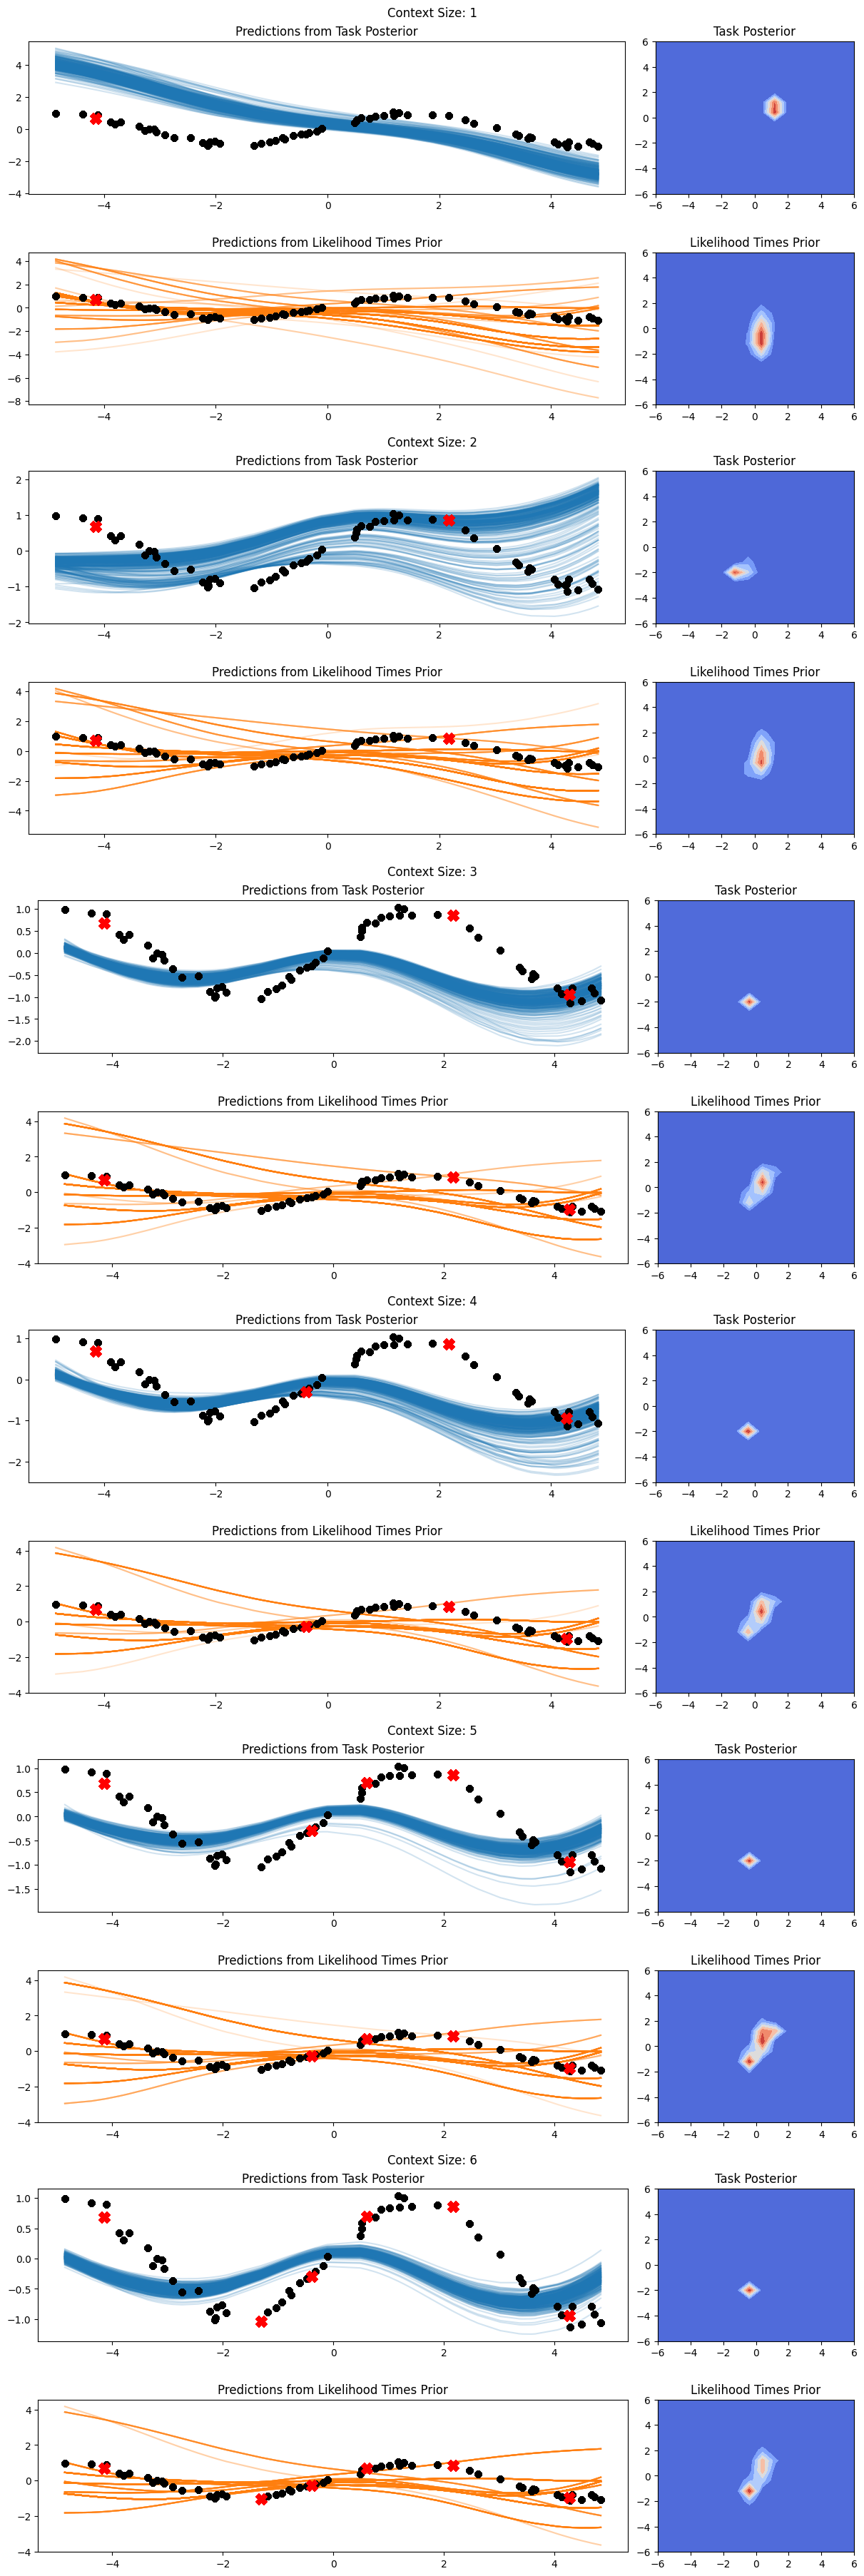

In [15]:
max_context_size = 6
num_samples = 256
gen_dataloader = DataLoader(val_loader.dataset, 1, True)

ranges = [(-6, 6), (-6, 6)]

targets, samples = visualize_cdvi_for_bml_test(
    device=device,
    cdvi=cdvi,
    dataloader=gen_dataloader,
    config=cfg,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)

In [ ]:
torch.save(cdvi.state_dict(), f"{dir}/cdvi_finetuned.pth")